In [1]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import LearningRateScheduler,ModelCheckpoint,TensorBoard
from keras.optimizers import RMSprop,SGD,Adam
from keras.applications import ResNet50,VGG16,VGG19,InceptionV3,ResNet152V2,vgg16
from keras.applications import DenseNet121,DenseNet169,DenseNet201
from keras.applications import NASNetMobile, NASNetLarge, EfficientNetB0, EfficientNetV2B0
from keras.layers import Input, Dropout,Flatten,Dense,GlobalAveragePooling2D
from keras.models import Model,load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.applications import imagenet_utils
from imutils import paths
from random import shuffle
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt
import h5py
import cv2
from csv import reader


#Needed for top layers of model
from tensorflow.keras.layers import BatchNormalization
from keras import regularizers

#Adds top classification layer to transfer learning model
def top_layers(baseModel, classes, D):
	# initialize the head model that will be placed on top of
	# the base, then add a FC layer
	l2_constant=0.02
	first_dropout_rate=0.5
	dropout_rate=0.5
	headModel = baseModel.output
	headModel = GlobalAveragePooling2D()(headModel)
	headModel = Flatten()(headModel)
	headModel = Dense(D, activation="relu",kernel_regularizer=regularizers.l2(l2_constant))(headModel)

	# add a softmax layer
	headModel = Dense(classes, activation="softmax")(headModel)

	# return the model
	return headModel

#modifies learning rate based on epoch
def step_decay(epoch):
    initAlpha=.0020
    if epoch <= 20:
        alpha=initAlpha
    elif epoch <= 40:
        alpha=initAlpha*0.75
    elif epoch <= 60:
        alpha=initAlpha*0.50
    elif epoch <= 80:
        alpha=initAlpha*0.25
    elif epoch <=100:
        alpha=initAlpha*0.175
    elif epoch <= 125:
        alpha=initAlpha*0.10
    else:
        alpha=initAlpha*0.05
    return float(alpha)

#Loads in image data, labels from class subfolder
def create_data_arrays_list(imageData, image_dimension, verbose=-1):
    # initialize the list of features and labels
    data = []
    labels = []
    i=0

    # loop over the input images
    for image_input in imageData:
        # load the image
        
        image = cv2.imread("C:/Ceramic_Models/no_wepo/images/"+image_input[0][:])


        # resize image, convert image to grayscale, then back to original color scheme for ResNet50, VGG16
        #Original interpolation was cv2.INTER_AREA
        image = cv2.cvtColor(cv2.cvtColor(cv2.resize(image, (image_dimension, image_dimension),
            interpolation=cv2.INTER_AREA),cv2.COLOR_BGR2GRAY),cv2.COLOR_GRAY2BGR)
        
        #convert image into array format using Keras function
        image=img_to_array(image)

        #add image data to array
        data.append(image)
        
        #Change label names so that class numbers will correspond to chronological sequence; class names changed back further on
        if image_input[:][1] == 'Kanaa': append_label='00'+'Kanaa'
        elif image_input[:][1] == 'Black_Mesa': append_label='01'+'Black_Mesa'
        elif image_input[:][1] == 'Sosi': append_label='02'+'Sosi'
        elif image_input[:][1] == 'Dogoszhi': append_label='03'+'Dogoszhi'
        elif image_input[:][1] == 'Flagstaff': append_label='04'+'Flagstaff'
        elif image_input[:][1] == 'Tusayan': append_label='05'+'Tusayan'
        else: append_label='06'+'Kayenta'
        
        #write label name
        labels.append(append_label)

        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1,
            len(imageData)))
        i=i+1

    # return image array data, labels
    return (np.array(data), np.array(labels))

In [2]:
set_number="1"
run_number="1"

model_name="VGG16_no_test"
image_dimension=224

# load the model network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights='imagenet', include_top=False,
	input_tensor=Input(shape=(image_dimension, image_dimension, 3)))

# initialize the new head of the network, a set of FC layers
# followed by a softmax classifier

#Class_size=Number of classes
Class_size=7
headModel = top_layers(baseModel, Class_size, 512)

# place the head FC model on top of the base model -- this will
# become the actual model we will train
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they
# will *not* be updated during the training process
for layer in baseModel.layers:
	layer.trainable = False

print(model_name + " model loaded")

model_id=model_name+ "_"+set_number+"_"+run_number
print(model_id)

image_directory="C:/Ceramic_Models/no_wepo/"
#Define directories to use based on set number for loading data, saving data
train_dataset=image_directory + model_name + "/Set_" + set_number +"/train_" + set_number + ".csv"
test_dataset=image_directory + model_name + "/Set_" + set_number +"/test_" + set_number + ".csv"
#Tboard_dir = "C:\Ceramic_Models\load_test\Set_" + set_number +"\tb"
models_dir = image_directory + model_name + "/Set_" + set_number +"/models"
images_dir = image_directory+"images/"
print(train_dataset)
print(test_dataset)

VGG16_no_test model loaded
VGG16_no_test_1_1
C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/train_1.csv
C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/test_1.csv


In [4]:
#Parameters for ImageDataGenerator
shift=0.0
zoom=0.3


# construct the image generator for data augmentation
#fill_mode is value put into empty spaces created by rotation or zooming; cval=1.0 means white
aug = ImageDataGenerator(rotation_range=180,
	horizontal_flip=False, vertical_flip=False, width_shift_range=shift, height_shift_range=shift, zoom_range=zoom, fill_mode="constant",cval=1.0)

In [6]:
# Get lists of train images, types from file
print("[INFO] loading images...")
with open(train_dataset, 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    # Pass reader object to list() to get a list of lists
    train_data_list = list(csv_reader)

#close file
read_obj.close()

#randomize order of images
shuffle(train_data_list)

#same for test images, types
with open(test_dataset, 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = reader(read_obj)
    # Pass reader object to list() to get a list of lists
    test_data_list = list(csv_reader)


read_obj.close()

(train_data,train_labels)=create_data_arrays_list(train_data_list,image_dimension, verbose=250)

(test_data,test_labels)=create_data_arrays_list(test_data_list,image_dimension,verbose=250)

#Set classNames from train_labels list, rename to eliminate numbers from the front
classNames = [str(x) for x in np.unique(train_labels)]
classNames=['Kanaa',  'Black_Mesa', 'Sosi', 'Dogoszhi', 'Flagstaff', 'Tusayan', 'Kayenta']

train_data = train_data.astype("float")
train_data = vgg16.preprocess_input(train_data)
print("Training data loaded")

#Load test data separately
test_data = test_data.astype("float") 
test_data = vgg16.preprocess_input(test_data)
print("Test data loaded")


# set X,Y values to values for train, test
(trainX, testX, trainY, testY) = (train_data,test_data,train_labels,test_labels)

# convert the labels from integers to vectors
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

print("Done!")
x = np.mean(train_data)
y = np.std(train_data)
print("Mean: " + str(x) + " Std: " + str(y))


[INFO] loading images...
[INFO] processed 250/1877
[INFO] processed 500/1877
[INFO] processed 750/1877
[INFO] processed 1000/1877
[INFO] processed 1250/1877
[INFO] processed 1500/1877
[INFO] processed 1750/1877
[INFO] processed 250/470
Training data loaded
Test data loaded
Done!
Mean: 203.60538525063063 Std: 61.51054341179457


In [9]:
# compile  model after setting base model layers to be non-trainable
print("[INFO] compiling model...")
#Gradient descent optimization algorithm
opt = RMSprop(learning_rate=0.0025)
#opt = SGD(learning_rate=0.0025)
#opt = Adam(learning_rate=0.001)
#Compile, specify loss, optimizer, metrics
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

#Add Learning rate scheduler to model callbacks
callbacks=[LearningRateScheduler(step_decay)]

# train the head of the network x epochs; other layers frozen to prevent randomization
print("[INFO] training head...")

epoch_head = 10
#model.fit(aug.flow(trainX, trainY, batch_size=32),
#	validation_data=(testX, testY), epochs=epoch_head,
#	steps_per_epoch=len(trainX) // 32, callbacks=callbacks,verbose=1)

model.fit(aug.flow(trainX, trainY, batch_size=32),
	 epochs=epoch_head,
	steps_per_epoch=len(trainX) // 32, callbacks=callbacks,verbose=1)

[INFO] compiling model...
[INFO] training head...
Epoch 1/10
58/58 [==============================] - 19s 210ms/step - loss: 7.9520 - accuracy: 0.3653 - lr: 0.0020
Epoch 2/10
58/58 [==============================] - 10s 171ms/step - loss: 3.1501 - accuracy: 0.4195 - lr: 0.0020
Epoch 3/10
58/58 [==============================] - 10s 171ms/step - loss: 2.3884 - accuracy: 0.4596 - lr: 0.0020
Epoch 4/10
58/58 [==============================] - 10s 172ms/step - loss: 2.0604 - accuracy: 0.4531 - lr: 0.0020
Epoch 5/10
58/58 [==============================] - 10s 171ms/step - loss: 2.0032 - accuracy: 0.4634 - lr: 0.0020
Epoch 6/10
58/58 [==============================] - 10s 171ms/step - loss: 1.9530 - accuracy: 0.4661 - lr: 0.0020
Epoch 7/10
58/58 [==============================] - 10s 171ms/step - loss: 1.9929 - accuracy: 0.4650 - lr: 0.0020
Epoch 8/10
58/58 [==============================] - 10s 172ms/step - loss: 1.8411 - accuracy: 0.5051 - lr: 0.0020
Epoch 9/10
58/58 [====================

In [10]:
batch_size=16
full_model_path = os.path.join(models_dir,'',model_id +'.model')
#Set callbacks for final run, including saving models based on best validation accuracy
#callbacks=[LearningRateScheduler(step_decay),ModelCheckpoint(full_model_path, monitor='val_accuracy', verbose=1,save_best_only=True,
#          save_weights_only=False,mode='max',save_freq='epoch')]

callbacks=[LearningRateScheduler(step_decay),ModelCheckpoint(full_model_path, monitor='accuracy', verbose=1,save_best_only=True,
          save_weights_only=False,mode='max',save_freq='epoch')]

# unfreeze the initial set of deep layers  and make them trainable; remember 0-based count!
for layer in baseModel.layers[0:]:
	layer.trainable = True

# for the changes to the model to take affect we need to recompile
# the model, this time using SGD with a *very* small learning rate
print("[INFO] re-compiling model...")
opt = SGD(learning_rate=0.005)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
print("Final model compiled")

# train the model again, this time fine-tuning the full set of CONV layers
print("[INFO] fine-tuning model...")
epoch_full=100
#H=model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
#	validation_data=(testX, testY), epochs=epoch_full,
#	steps_per_epoch=len(trainX) // batch_size, callbacks=callbacks, verbose=1)

H=model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
	 epochs=epoch_full,
	steps_per_epoch=len(trainX) // batch_size, callbacks=callbacks, verbose=1)

model_best = load_model(full_model_path)

[INFO] re-compiling model...
Final model compiled
[INFO] fine-tuning model...
Epoch 1/100
117/117 [==============================] - ETA: 0s - loss: 1.2390 - accuracy: 0.6389
Epoch 1: accuracy improved from -inf to 0.63890, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 25s 181ms/step - loss: 1.2390 - accuracy: 0.6389 - lr: 0.0020
Epoch 2/100
117/117 [==============================] - ETA: 0s - loss: 1.0105 - accuracy: 0.7098
Epoch 2: accuracy improved from 0.63890 to 0.70983, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 20s 175ms/step - loss: 1.0105 - accuracy: 0.7098 - lr: 0.0020
Epoch 3/100
117/117 [==============================] - ETA: 0s - loss: 0.9162 - accuracy: 0.7399
Epoch 3: accuracy improved from 0.70983 to 0.73992, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 177ms/step - loss: 0.9162 - accuracy: 0.7399 - lr: 0.0020
Epoch 4/100
117/117 [==============================] - ETA: 0s - loss: 0.8157 - accuracy: 0.7689
Epoch 4: accuracy improved from 0.73992 to 0.76894, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 178ms/step - loss: 0.8157 - accuracy: 0.7689 - lr: 0.0020
Epoch 5/100
117/117 [==============================] - ETA: 0s - loss: 0.8144 - accuracy: 0.7877
Epoch 5: accuracy improved from 0.76894 to 0.78775, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 177ms/step - loss: 0.8144 - accuracy: 0.7877 - lr: 0.0020
Epoch 6/100
117/117 [==============================] - ETA: 0s - loss: 0.7617 - accuracy: 0.7937
Epoch 6: accuracy improved from 0.78775 to 0.79366, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 178ms/step - loss: 0.7617 - accuracy: 0.7937 - lr: 0.0020
Epoch 7/100
117/117 [==============================] - ETA: 0s - loss: 0.7561 - accuracy: 0.8049
Epoch 7: accuracy improved from 0.79366 to 0.80494, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 177ms/step - loss: 0.7561 - accuracy: 0.8049 - lr: 0.0020
Epoch 8/100
117/117 [==============================] - ETA: 0s - loss: 0.7066 - accuracy: 0.8195
Epoch 8: accuracy improved from 0.80494 to 0.81945, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 179ms/step - loss: 0.7066 - accuracy: 0.8195 - lr: 0.0020
Epoch 9/100
117/117 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.8227
Epoch 9: accuracy improved from 0.81945 to 0.82268, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 175ms/step - loss: 0.6855 - accuracy: 0.8227 - lr: 0.0020
Epoch 10/100
117/117 [==============================] - ETA: 0s - loss: 0.6440 - accuracy: 0.8452
Epoch 10: accuracy improved from 0.82268 to 0.84524, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 176ms/step - loss: 0.6440 - accuracy: 0.8452 - lr: 0.0020
Epoch 11/100
117/117 [==============================] - ETA: 0s - loss: 0.6350 - accuracy: 0.8377
Epoch 11: accuracy did not improve from 0.84524
117/117 [==============================] - 20s 166ms/step - loss: 0.6350 - accuracy: 0.8377 - lr: 0.0020
Epoch 12/100
117/117 [==============================] - ETA: 0s - loss: 0.5996 - accuracy: 0.8522
Epoch 12: accuracy improved from 0.84524 to 0.85223, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 178ms/step - loss: 0.5996 - accuracy: 0.8522 - lr: 0.0020
Epoch 13/100
117/117 [==============================] - ETA: 0s - loss: 0.5781 - accuracy: 0.8571
Epoch 13: accuracy improved from 0.85223 to 0.85707, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 177ms/step - loss: 0.5781 - accuracy: 0.8571 - lr: 0.0020
Epoch 14/100
117/117 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.8716
Epoch 14: accuracy improved from 0.85707 to 0.87157, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 181ms/step - loss: 0.5503 - accuracy: 0.8716 - lr: 0.0020
Epoch 15/100
117/117 [==============================] - ETA: 0s - loss: 0.5470 - accuracy: 0.8641
Epoch 15: accuracy did not improve from 0.87157
117/117 [==============================] - 19s 164ms/step - loss: 0.5470 - accuracy: 0.8641 - lr: 0.0020
Epoch 16/100
117/117 [==============================] - ETA: 0s - loss: 0.5315 - accuracy: 0.8780
Epoch 16: accuracy improved from 0.87157 to 0.87802, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 176ms/step - loss: 0.5315 - accuracy: 0.8780 - lr: 0.0020
Epoch 17/100
117/117 [==============================] - ETA: 0s - loss: 0.5011 - accuracy: 0.8877
Epoch 17: accuracy improved from 0.87802 to 0.88769, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 177ms/step - loss: 0.5011 - accuracy: 0.8877 - lr: 0.0020
Epoch 18/100
117/117 [==============================] - ETA: 0s - loss: 0.5002 - accuracy: 0.8850
Epoch 18: accuracy did not improve from 0.88769
117/117 [==============================] - 19s 163ms/step - loss: 0.5002 - accuracy: 0.8850 - lr: 0.0020
Epoch 19/100
117/117 [==============================] - ETA: 0s - loss: 0.4853 - accuracy: 0.8915
Epoch 19: accuracy improved from 0.88769 to 0.89146, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 177ms/step - loss: 0.4853 - accuracy: 0.8915 - lr: 0.0020
Epoch 20/100
117/117 [==============================] - ETA: 0s - loss: 0.4864 - accuracy: 0.8925
Epoch 20: accuracy improved from 0.89146 to 0.89253, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 176ms/step - loss: 0.4864 - accuracy: 0.8925 - lr: 0.0020
Epoch 21/100
117/117 [==============================] - ETA: 0s - loss: 0.4848 - accuracy: 0.8882
Epoch 21: accuracy did not improve from 0.89253
117/117 [==============================] - 19s 161ms/step - loss: 0.4848 - accuracy: 0.8882 - lr: 0.0020
Epoch 22/100
117/117 [==============================] - ETA: 0s - loss: 0.3994 - accuracy: 0.9135
Epoch 22: accuracy improved from 0.89253 to 0.91349, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 175ms/step - loss: 0.3994 - accuracy: 0.9135 - lr: 0.0015
Epoch 23/100
117/117 [==============================] - ETA: 0s - loss: 0.3923 - accuracy: 0.9178
Epoch 23: accuracy improved from 0.91349 to 0.91779, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 175ms/step - loss: 0.3923 - accuracy: 0.9178 - lr: 0.0015
Epoch 24/100
117/117 [==============================] - ETA: 0s - loss: 0.3827 - accuracy: 0.9215
Epoch 24: accuracy improved from 0.91779 to 0.92155, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 177ms/step - loss: 0.3827 - accuracy: 0.9215 - lr: 0.0015
Epoch 25/100
117/117 [==============================] - ETA: 0s - loss: 0.3713 - accuracy: 0.9194
Epoch 25: accuracy did not improve from 0.92155
117/117 [==============================] - 19s 161ms/step - loss: 0.3713 - accuracy: 0.9194 - lr: 0.0015
Epoch 26/100
117/117 [==============================] - ETA: 0s - loss: 0.3634 - accuracy: 0.9258
Epoch 26: accuracy improved from 0.92155 to 0.92585, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 175ms/step - loss: 0.3634 - accuracy: 0.9258 - lr: 0.0015
Epoch 27/100
117/117 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.9323
Epoch 27: accuracy improved from 0.92585 to 0.93229, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 176ms/step - loss: 0.3573 - accuracy: 0.9323 - lr: 0.0015
Epoch 28/100
117/117 [==============================] - ETA: 0s - loss: 0.3494 - accuracy: 0.9312
Epoch 28: accuracy did not improve from 0.93229
117/117 [==============================] - 19s 161ms/step - loss: 0.3494 - accuracy: 0.9312 - lr: 0.0015
Epoch 29/100
117/117 [==============================] - ETA: 0s - loss: 0.3482 - accuracy: 0.9226
Epoch 29: accuracy did not improve from 0.93229
117/117 [==============================] - 19s 161ms/step - loss: 0.3482 - accuracy: 0.9226 - lr: 0.0015
Epoch 30/100
117/117 [==============================] - ETA: 0s - loss: 0.3356 - accuracy: 0.9371
Epoch 30: accuracy improved from 0.93229 to 0.93713, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 175ms/step - loss: 0.3356 - accuracy: 0.9371 - lr: 0.0015
Epoch 31/100
117/117 [==============================] - ETA: 0s - loss: 0.3459 - accuracy: 0.9280
Epoch 31: accuracy did not improve from 0.93713
117/117 [==============================] - 19s 161ms/step - loss: 0.3459 - accuracy: 0.9280 - lr: 0.0015
Epoch 32/100
117/117 [==============================] - ETA: 0s - loss: 0.3574 - accuracy: 0.9301
Epoch 32: accuracy did not improve from 0.93713
117/117 [==============================] - 19s 162ms/step - loss: 0.3574 - accuracy: 0.9301 - lr: 0.0015
Epoch 33/100
117/117 [==============================] - ETA: 0s - loss: 0.3166 - accuracy: 0.9371
Epoch 33: accuracy did not improve from 0.93713
117/117 [==============================] - 19s 164ms/step - loss: 0.3166 - accuracy: 0.9371 - lr: 0.0015
Epoch 34/100
117/117 [==============================] - ETA: 0s - loss: 0.3030 - accuracy: 0.9414
Epoch 34: accuracy improved from 0.93713 to 

INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 176ms/step - loss: 0.3030 - accuracy: 0.9414 - lr: 0.0015
Epoch 35/100
117/117 [==============================] - ETA: 0s - loss: 0.2791 - accuracy: 0.9522
Epoch 35: accuracy improved from 0.94143 to 0.95218, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 175ms/step - loss: 0.2791 - accuracy: 0.9522 - lr: 0.0015
Epoch 36/100
117/117 [==============================] - ETA: 0s - loss: 0.3083 - accuracy: 0.9366
Epoch 36: accuracy did not improve from 0.95218
117/117 [==============================] - 19s 161ms/step - loss: 0.3083 - accuracy: 0.9366 - lr: 0.0015
Epoch 37/100
117/117 [==============================] - ETA: 0s - loss: 0.3107 - accuracy: 0.9371
Epoch 37: accuracy did not improve from 0.95218
117/117 [==============================] - 19s 161ms/step - loss: 0.3107 - accuracy: 0.9371 - lr: 0.0015
Epoch 38/100
117/117 [==============================] - ETA: 0s - loss: 0.3028 - accuracy: 0.9425
Epoch 38: accuracy did not improve from 0.95218
117/117 [==============================] - 19s 161ms/step - loss: 0.3028 - accuracy: 0.9425 - lr: 0.0015
Epoch 39/100
117/117 [==============================] - ETA: 0s - loss: 0.2914 - accuracy: 0.9430
Epoch 39: accuracy did not improve from 0.95

INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 22s 186ms/step - loss: 0.2577 - accuracy: 0.9608 - lr: 0.0015
Epoch 42/100
117/117 [==============================] - ETA: 0s - loss: 0.2309 - accuracy: 0.9586
Epoch 42: accuracy did not improve from 0.96077
117/117 [==============================] - 20s 166ms/step - loss: 0.2309 - accuracy: 0.9586 - lr: 0.0010
Epoch 43/100
117/117 [==============================] - ETA: 0s - loss: 0.2161 - accuracy: 0.9694
Epoch 43: accuracy improved from 0.96077 to 0.96937, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 175ms/step - loss: 0.2161 - accuracy: 0.9694 - lr: 0.0010
Epoch 44/100
117/117 [==============================] - ETA: 0s - loss: 0.2114 - accuracy: 0.9731
Epoch 44: accuracy improved from 0.96937 to 0.97313, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 175ms/step - loss: 0.2114 - accuracy: 0.9731 - lr: 0.0010
Epoch 45/100
117/117 [==============================] - ETA: 0s - loss: 0.2113 - accuracy: 0.9699
Epoch 45: accuracy did not improve from 0.97313
117/117 [==============================] - 20s 166ms/step - loss: 0.2113 - accuracy: 0.9699 - lr: 0.0010
Epoch 46/100
117/117 [==============================] - ETA: 0s - loss: 0.2212 - accuracy: 0.9667
Epoch 46: accuracy did not improve from 0.97313
117/117 [==============================] - 20s 167ms/step - loss: 0.2212 - accuracy: 0.9667 - lr: 0.0010
Epoch 47/100
117/117 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.9753
Epoch 47: accuracy improved from 0.97313 to 0.97528, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 182ms/step - loss: 0.2032 - accuracy: 0.9753 - lr: 0.0010
Epoch 48/100
117/117 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.9726
Epoch 48: accuracy did not improve from 0.97528
117/117 [==============================] - 20s 166ms/step - loss: 0.2007 - accuracy: 0.9726 - lr: 0.0010
Epoch 49/100
117/117 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 0.9753
Epoch 49: accuracy did not improve from 0.97528
117/117 [==============================] - 19s 164ms/step - loss: 0.2004 - accuracy: 0.9753 - lr: 0.0010
Epoch 50/100
117/117 [==============================] - ETA: 0s - loss: 0.1916 - accuracy: 0.9758
Epoch 50: accuracy improved from 0.97528 to 0.97582, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 177ms/step - loss: 0.1916 - accuracy: 0.9758 - lr: 0.0010
Epoch 51/100
117/117 [==============================] - ETA: 0s - loss: 0.1980 - accuracy: 0.9715
Epoch 51: accuracy did not improve from 0.97582
117/117 [==============================] - 19s 163ms/step - loss: 0.1980 - accuracy: 0.9715 - lr: 0.0010
Epoch 52/100
117/117 [==============================] - ETA: 0s - loss: 0.2149 - accuracy: 0.9635
Epoch 52: accuracy did not improve from 0.97582
117/117 [==============================] - 19s 162ms/step - loss: 0.2149 - accuracy: 0.9635 - lr: 0.0010
Epoch 53/100
117/117 [==============================] - ETA: 0s - loss: 0.2087 - accuracy: 0.9694
Epoch 53: accuracy did not improve from 0.97582
117/117 [==============================] - 19s 162ms/step - loss: 0.2087 - accuracy: 0.9694 - lr: 0.0010
Epoch 54/100
117/117 [==============================] - ETA: 0s - loss: 0.2036 - accuracy: 0.9688
Epoch 54: accuracy did not improve from 0.97

INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 177ms/step - loss: 0.1900 - accuracy: 0.9780 - lr: 0.0010
Epoch 56/100
117/117 [==============================] - ETA: 0s - loss: 0.1870 - accuracy: 0.9737
Epoch 56: accuracy did not improve from 0.97797
117/117 [==============================] - 19s 163ms/step - loss: 0.1870 - accuracy: 0.9737 - lr: 0.0010
Epoch 57/100
117/117 [==============================] - ETA: 0s - loss: 0.2158 - accuracy: 0.9602
Epoch 57: accuracy did not improve from 0.97797
117/117 [==============================] - 19s 162ms/step - loss: 0.2158 - accuracy: 0.9602 - lr: 0.0010
Epoch 58/100
117/117 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.9758
Epoch 58: accuracy did not improve from 0.97797
117/117 [==============================] - 19s 162ms/step - loss: 0.1802 - accuracy: 0.9758 - lr: 0.0010
Epoch 59/100
117/117 [==============================] - ETA: 0s - loss: 0.1743 - accuracy: 0.9828
Epoch 59: accuracy improved from 0.97797 to 

INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 175ms/step - loss: 0.1743 - accuracy: 0.9828 - lr: 0.0010
Epoch 60/100
117/117 [==============================] - ETA: 0s - loss: 0.1831 - accuracy: 0.9801
Epoch 60: accuracy did not improve from 0.98280
117/117 [==============================] - 19s 162ms/step - loss: 0.1831 - accuracy: 0.9801 - lr: 0.0010
Epoch 61/100
117/117 [==============================] - ETA: 0s - loss: 0.1709 - accuracy: 0.9839
Epoch 61: accuracy improved from 0.98280 to 0.98388, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 177ms/step - loss: 0.1709 - accuracy: 0.9839 - lr: 0.0010
Epoch 62/100
117/117 [==============================] - ETA: 0s - loss: 0.1545 - accuracy: 0.9903
Epoch 62: accuracy improved from 0.98388 to 0.99033, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 175ms/step - loss: 0.1545 - accuracy: 0.9903 - lr: 5.0000e-04
Epoch 63/100
117/117 [==============================] - ETA: 0s - loss: 0.1456 - accuracy: 0.9887
Epoch 63: accuracy did not improve from 0.99033
117/117 [==============================] - 19s 161ms/step - loss: 0.1456 - accuracy: 0.9887 - lr: 5.0000e-04
Epoch 64/100
117/117 [==============================] - ETA: 0s - loss: 0.1478 - accuracy: 0.9914
Epoch 64: accuracy improved from 0.99033 to 0.99140, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 176ms/step - loss: 0.1478 - accuracy: 0.9914 - lr: 5.0000e-04
Epoch 65/100
117/117 [==============================] - ETA: 0s - loss: 0.1473 - accuracy: 0.9893
Epoch 65: accuracy did not improve from 0.99140
117/117 [==============================] - 19s 161ms/step - loss: 0.1473 - accuracy: 0.9893 - lr: 5.0000e-04
Epoch 66/100
117/117 [==============================] - ETA: 0s - loss: 0.1367 - accuracy: 0.9936
Epoch 66: accuracy improved from 0.99140 to 0.99355, saving model to C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 177ms/step - loss: 0.1367 - accuracy: 0.9936 - lr: 5.0000e-04
Epoch 67/100
117/117 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.9925
Epoch 67: accuracy did not improve from 0.99355
117/117 [==============================] - 19s 161ms/step - loss: 0.1388 - accuracy: 0.9925 - lr: 5.0000e-04
Epoch 68/100
117/117 [==============================] - ETA: 0s - loss: 0.1422 - accuracy: 0.9909
Epoch 68: accuracy did not improve from 0.99355
117/117 [==============================] - 19s 161ms/step - loss: 0.1422 - accuracy: 0.9909 - lr: 5.0000e-04
Epoch 69/100
117/117 [==============================] - ETA: 0s - loss: 0.1477 - accuracy: 0.9876
Epoch 69: accuracy did not improve from 0.99355
117/117 [==============================] - 19s 162ms/step - loss: 0.1477 - accuracy: 0.9876 - lr: 5.0000e-04
Epoch 70/100
117/117 [==============================] - ETA: 0s - loss: 0.1427 - accuracy: 0.9909
Epoch 70: accuracy did not i

INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


INFO:tensorflow:Assets written to: C:/Ceramic_Models/no_wepo/VGG16_no_test/Set_1/models\VGG16_no_test_1_1.model\assets


117/117 [==============================] - 21s 176ms/step - loss: 0.1247 - accuracy: 0.9962 - lr: 5.0000e-04
Epoch 76/100
117/117 [==============================] - ETA: 0s - loss: 0.1276 - accuracy: 0.9930
Epoch 76: accuracy did not improve from 0.99624
117/117 [==============================] - 19s 162ms/step - loss: 0.1276 - accuracy: 0.9930 - lr: 5.0000e-04
Epoch 77/100
117/117 [==============================] - ETA: 0s - loss: 0.1274 - accuracy: 0.9957
Epoch 77: accuracy did not improve from 0.99624
117/117 [==============================] - 19s 162ms/step - loss: 0.1274 - accuracy: 0.9957 - lr: 5.0000e-04
Epoch 78/100
117/117 [==============================] - ETA: 0s - loss: 0.1339 - accuracy: 0.9903
Epoch 78: accuracy did not improve from 0.99624
117/117 [==============================] - 19s 165ms/step - loss: 0.1339 - accuracy: 0.9903 - lr: 5.0000e-04
Epoch 79/100
117/117 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.9909
Epoch 79: accuracy did not i

[INFO] evaluating train data ...
118/118 [==============================] - 5s 42ms/step
              precision    recall  f1-score   support

       Kanaa       1.00      0.99      1.00       112
  Black_Mesa       0.96      1.00      0.98       421
        Sosi       1.00      0.96      0.98       483
    Dogoszhi       1.00      1.00      1.00       209
   Flagstaff       0.99      1.00      1.00       171
     Tusayan       1.00      1.00      1.00       414
     Kayenta       1.00      1.00      1.00        67

    accuracy                           0.99      1877
   macro avg       0.99      0.99      0.99      1877
weighted avg       0.99      0.99      0.99      1877

Confusion matrix
['Kanaa', 'Black_Mesa', 'Sosi', 'Dogoszhi', 'Flagstaff', 'Tusayan', 'Kayenta']
[[111   0   0   1   0   0   0]
 [  0 421   0   0   0   0   0]
 [  0  16 466   0   1   0   0]
 [  0   0   0 209   0   0   0]
 [  0   0   0   0 171   0   0]
 [  0   1   0   0   0 413   0]
 [  0   0   0   0   0   0  67]]


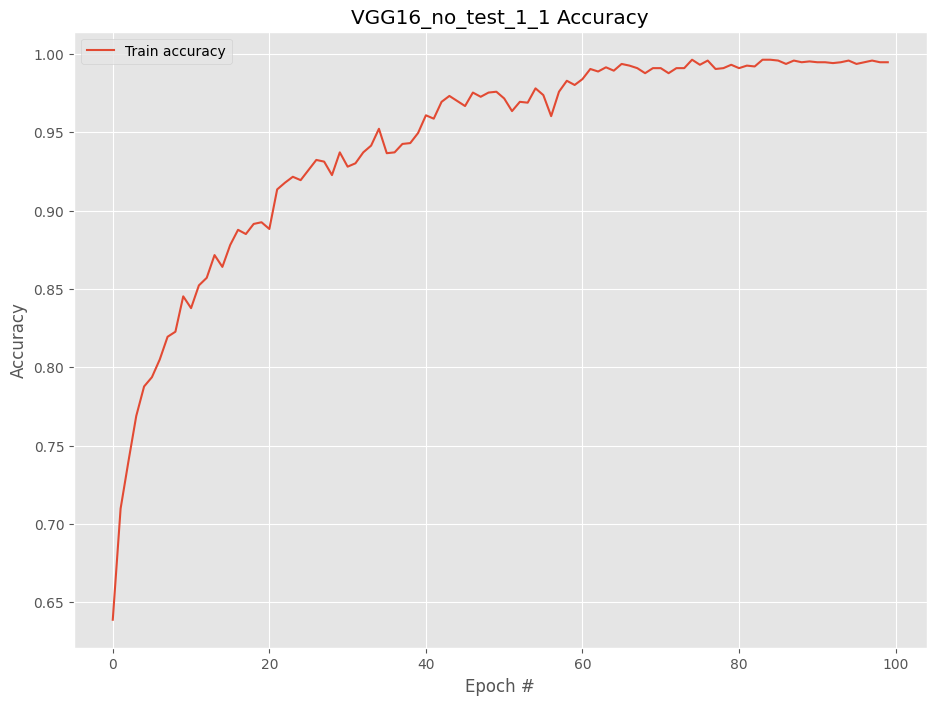

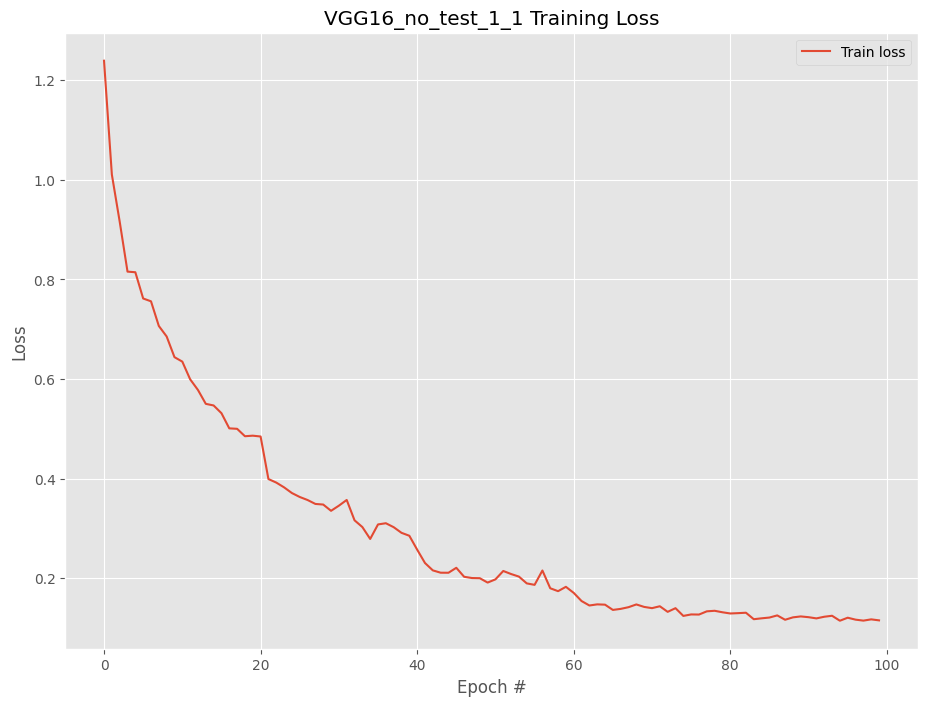

In [11]:
# evaluate train data
print("[INFO] evaluating train data ...")
predictions = model_best.predict(trainX, batch_size=16)
class_report=classification_report(trainY.argmax(axis=1), predictions.argmax(axis=1), target_names=classNames)
class_file=open(full_model_path  + "_train_class_report.txt","w")
class_file.write(class_report)
class_file.close()
print(class_report)
#print(classification_report(np.argmax(testY,axis=1), predictions.argmax(axis=1),target_names=classNames))
print("Confusion matrix")
print(classNames)
con_mat=confusion_matrix(np.argmax(trainY,axis=1), predictions.argmax(axis=1))
#print(confusion_matrix(np.argmax(testY,axis=1), predictions.argmax(axis=1)))
print(con_mat)
#confusion_matrix(np.argmax(testY,axis=1), predictions.argmax(axis=1))
np.savetxt(full_model_path  + "_train_confusion_matrix.csv", con_mat, delimiter=",")


np.savetxt(full_model_path  + "_test_confusion_matrix.csv", con_mat, delimiter=",")

# plot the accuracy
plt.style.use("ggplot")
plt.figure(figsize=(11, 8))
plt.plot(np.arange(0, epoch_full), H.history["accuracy"], label="Train accuracy")
#plt.plot(np.arange(0, epoch_full), H.history["val_accuracy"], label="Test accuracy")
plt.title(model_id + " Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(full_model_path + "_accuracy_plot.png")
#plt.show()

# plot the training loss
plt.style.use("ggplot")
plt.figure(figsize=(11, 8))
plt.plot(np.arange(0, epoch_full), H.history["loss"], label="Train loss")
#plt.plot(np.arange(0, epoch_full), H.history["val_loss"], label="Test loss")
plt.title(model_id + " Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.savefig(full_model_path  + "_loss_plot.png")
#plt.show()

In [ ]:

# evaluate test data
print("[INFO] evaluating test data ...")
predictions = model_best.predict(testX, batch_size=16)
class_report=classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=classNames)
class_file=open(full_model_path  + "_test_class_report.txt","w")
class_file.write(class_report)
class_file.close()
print(class_report)
#print(classification_report(np.argmax(testY,axis=1), predictions.argmax(axis=1),target_names=classNames))
print("Confusion matrix")
print(classNames)
con_mat=confusion_matrix(np.argmax(testY,axis=1), predictions.argmax(axis=1))
#print(confusion_matrix(np.argmax(testY,axis=1), predictions.argmax(axis=1)))
print(con_mat)
#confusion_matrix(np.argmax(testY,axis=1), predictions.argmax(axis=1))